In [15]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
import cv2
import json
import glob
from tqdm.notebook import tqdm
from torchvision import transforms

In [16]:
from feature_extraction import extract_dino_features

In [17]:
img_path = "input/frame_0001.png"
img = Image.open(img_path).convert('RGB')

features = extract_dino_features(img)
features.shape

torch.Size([1, 1369, 1024])

In [14]:
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')


Using cache found in C:\Users\ykirc/.cache\torch\hub\facebookresearch_dinov2_main


In [15]:
transform1 = transforms.Compose([           
                                transforms.Resize(520),
                                transforms.CenterCrop(518), #should be multiple of model patch_size                 
                                transforms.ToTensor(),                    
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])

patch_size = dinov2_vitl14.patch_size # patchsize=14

#520//14
patch_h  = 520//patch_size
patch_w  = 520//patch_size

feat_dim = 1024 # vitl14

In [29]:
folder_path = "C:/Users/ykirc/Documents/GitHub/Gaussian-Segmentation/experimentation/input/"
total_features  = []
with torch.no_grad():
  for img_path in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_path)
    img = Image.open(img_path).convert('RGB')
    img_t = transform1(img)
    
    features_dict = dinov2_vitl14.forward_features(img_t.unsqueeze(0))
    features = features_dict['x_norm_patchtokens']
    total_features.append(features)

total_features = torch.cat(total_features, dim=0)
total_features.shape

torch.Size([4, 1369, 1024])

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for traning
total_features = total_features.reshape(4 * patch_h * patch_w, feat_dim) #4(*H*w, 1024)

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

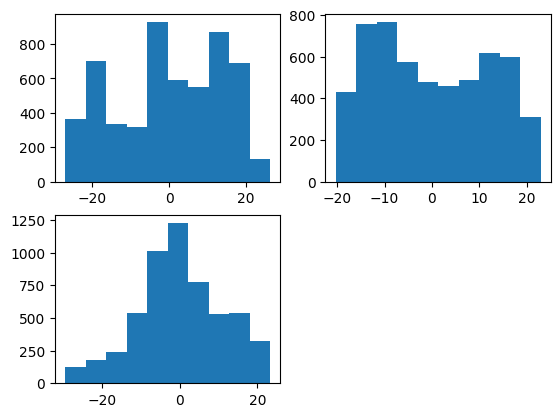

In [31]:
# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

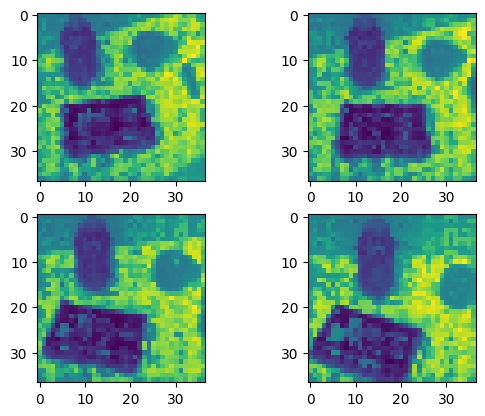

In [32]:
# min_max scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
#pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w))

plt.show()

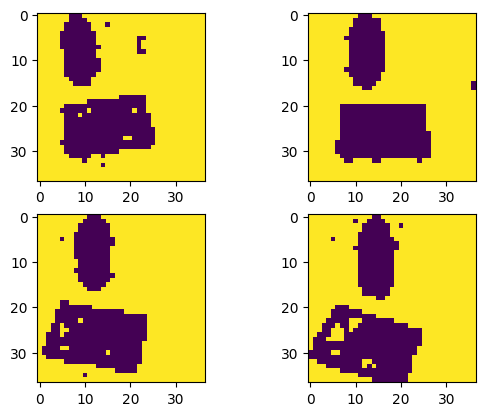

In [33]:

# segment/seperate the backgound and foreground using the first component
pca_features_bg = pca_features[:, 0] > 0.35 # from first histogram
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()


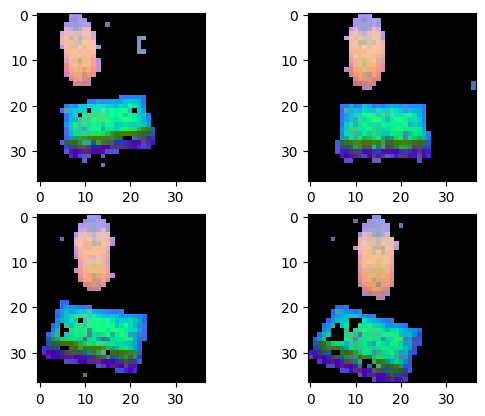

In [34]:
# 2nd PCA for only foreground patches
pca.fit(total_features[pca_features_fg]) 
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()
     

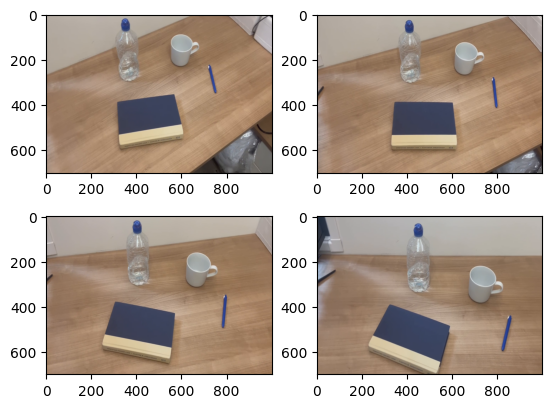

In [35]:
for i,img_path in enumerate(os.listdir(folder_path)):
  img_path = os.path.join(folder_path, img_path)
  img = Image.open(img_path).convert('RGB').resize((1000, 700))
  plt.subplot(2, 2, i+1)
  plt.imshow(img)

plt.show()
     

In [1]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
import cv2
import json
import glob
from tqdm.notebook import tqdm
from torchvision import transforms

# Load the DINO v2 model
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14').eval().cuda()

# Define a transform to preprocess the images for DINO v2
transform = transforms.Compose([
    transforms.Resize(520),
    transforms.CenterCrop(518),  # should be multiple of model patch_size
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.2)
])


def extract_dino_features(image):
    """
    Extract DINO v2 features from a single image.
    
    Parameters:
        image (PIL.Image): Input image.
        
    Returns:
        torch.Tensor: Extracted features.
    """
    # Transform the image
    img_t = transform(image).unsqueeze(0).cuda()  # Transform and add batch dimension
    
    # Extract features
    with torch.no_grad():
        features_dict = dinov2_vitl14.forward_features(img_t)
        features = features_dict['x_norm_patchtokens']
        
    return features

Using cache found in C:\Users\ykirc/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\ykirc/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\ykirc/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\ykirc/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [2]:
def visualize_features(features):
    """
    Visualize the extracted features.
    
    Parameters:
        features (torch.Tensor): Extracted features.
    """
    # Convert features to numpy
    features_np = features.cpu().squeeze().numpy()
    
    # Normalize features to [0, 1]
    features_np = (features_np - features_np.min()) / (features_np.max() - features_np.min())
    
    # Visualize each feature map
    num_features = features_np.shape[0]
    grid_size = int(np.ceil(np.sqrt(num_features)))
    
    plt.figure(figsize=(15, 15))
    for i in range(num_features):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(features_np[i], cmap='viridis')
        plt.axis('off')
    plt.show()


In [21]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torchvision import transforms

# Load the DINO v2 model
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14').eval().cuda()

# Define a transform to preprocess the images for DINO v2
transform = transforms.Compose([
    transforms.Resize(520),
    transforms.CenterCrop(518),  # should be multiple of model patch_size
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.2)
])

def extract_dino_features(image):
    """
    Extract DINO v2 features from a single image.
    
    Parameters:
        image (PIL.Image): Input image.
        
    Returns:
        torch.Tensor: Extracted features.
    """
    # Transform the image
    img_t = transform(image).unsqueeze(0).cuda()  # Transform and add batch dimension
    
    # Extract features
    with torch.no_grad():
        features_dict = dinov2_vitl14.forward_features(img_t)
        features = features_dict['x_norm_patchtokens']
        
    return features

def pca_transform_features(features, n_components=3):
    """
    Apply PCA to the extracted features and return the transformed features.
    
    Parameters:
        features (torch.Tensor): Extracted features.
        n_components (int): Number of PCA components.
        
    Returns:
        np.ndarray: PCA-transformed features.
    """
    # Flatten the features to 2D
    batch_size, num_patches, feature_dim = features.shape
    features_flat = features.view(-1, feature_dim).cpu().numpy()
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(features_flat)
    
    # Normalize PCA features to [0, 1] range
    pca_features = (pca_features - pca_features.min(axis=0)) / (pca_features.max(axis=0) - pca_features.min(axis=0))
    
    return pca_features.reshape(batch_size, num_patches, n_components)

# Load and preprocess the image
input_image_path = "input/frame_0001.png"  # Replace with your image path
image = Image.open(input_image_path).convert('RGB')

# Extract features
features = extract_dino_features(image)

# Apply PCA transformation
patch_size = dinov2_vitl14.patch_size
patch_h, patch_w = 520 // patch_size, 520 // patch_size
pca_features = pca_transform_features(features, n_components=1)

Using cache found in C:\Users\ykirc/.cache\torch\hub\facebookresearch_dinov2_main


array([[[0.3181786 ],
        [0.32782838],
        [0.3316306 ],
        ...,
        [0.5303499 ],
        [0.5139969 ],
        [0.50123996]]], dtype=float32)

In [27]:
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14').eval().cuda()

# Define a transform to preprocess the images for DINO v2
transform = transforms.Compose([
    transforms.Resize(520),
    transforms.CenterCrop(518),  # should be multiple of model patch_size
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.2)
])

def extract_pca_features(image, n_components=1):
    """
    Extract PCA-transformed features from an image using DINO v2 model.
    
    Parameters:
        image_path (str): Path to the input image.
        n_components (int): Number of PCA components.
        
    Returns:
        np.ndarray: PCA-transformed features.
    """
    # Load and preprocess the image
    img_t = transform(image).unsqueeze(0).cuda()  # Transform and add batch dimension
    
    # Extract features using DINO v2 model
    with torch.no_grad():
        features_dict = dinov2_vitl14.forward_features(img_t)
        features = features_dict['x_norm_patchtokens']
    
    # Flatten the features to 2D
    batch_size, num_patches, feature_dim = features.shape
    features_flat = features.view(-1, feature_dim).cpu().numpy()
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(features_flat)
    
    # Normalize PCA features to [0, 1] range
    pca_features = (pca_features - pca_features.min(axis=0)) / (pca_features.max(axis=0) - pca_features.min(axis=0))
    
    return pca_features.reshape(batch_size, num_patches, n_components)


input_image_path = "input/frame_0001.png"  # Replace with your image path
image = Image.open(input_image_path).convert('RGB')

pca_features = extract_pca_features(input_image_path, n_components=1)

print("PCA Features Shape:", pca_features.shape)

Using cache found in C:\Users\ykirc/.cache\torch\hub\facebookresearch_dinov2_main


PCA Features Shape: (1, 1369, 1)


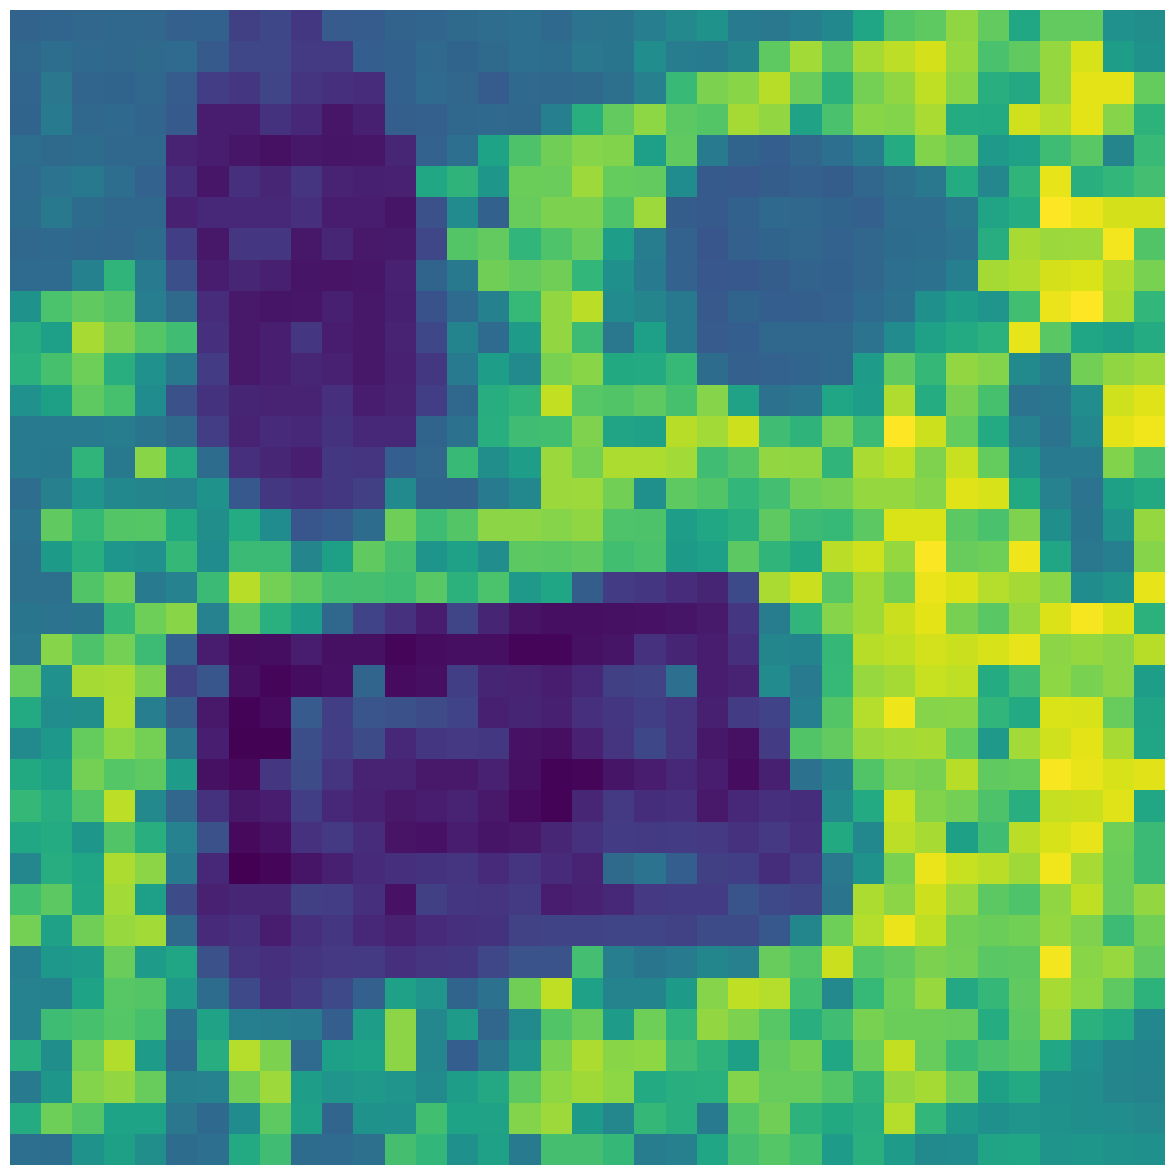

In [28]:
def visualize_pca_features(pca_features, patch_h, patch_w):
    """
    Visualize the PCA-transformed features.
    
    Parameters:
        pca_features (np.ndarray): PCA-transformed features.
        patch_h (int): Height of the patch grid.
        patch_w (int): Width of the patch grid.
    """
    batch_size, num_patches, _ = pca_features.shape
    pca_features = pca_features.reshape(batch_size, patch_h, patch_w, -1)
    
    plt.figure(figsize=(15, 15))
    for i in range(batch_size):
        for j in range(pca_features.shape[-1]):
            plt.subplot(batch_size, pca_features.shape[-1], i * pca_features.shape[-1] + j + 1)
            plt.imshow(pca_features[i, :, :, j], cmap='viridis')
            plt.axis('off')
    plt.show()

visualize_pca_features(pca_features, patch_h, patch_w)

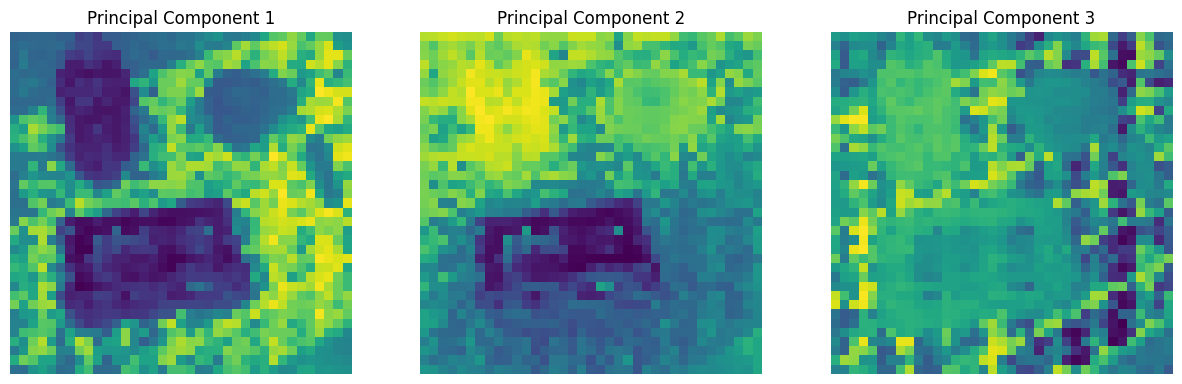

In [25]:
def visualize_pca_features(pca_features, patch_h, patch_w):
    """
    Visualize the PCA-transformed features.
    
    Parameters:
        pca_features (np.ndarray): PCA-transformed features.
        patch_h (int): Height of the patch grid.
        patch_w (int): Width of the patch grid.
    """
    batch_size, num_patches, num_components = pca_features.shape
    pca_features = pca_features.reshape(batch_size, patch_h, patch_w, num_components)
    
    plt.figure(figsize=(15, 15))
    for i in range(batch_size):
        for j in range(num_components):
            plt.subplot(batch_size, num_components, i * num_components + j + 1)
            plt.imshow(pca_features[i, :, :, j], cmap='viridis')
            plt.title(f"Principal Component {j+1}")
            plt.axis('off')
    plt.show()

# Load and preprocess the image
input_image_path = "input/frame_0001.png"  # Replace with your image path
image = Image.open(input_image_path).convert('RGB')

# Extract features
features = extract_dino_features(image)

# Apply PCA transformation
patch_size = dinov2_vitl14.patch_size
patch_h, patch_w = 520 // patch_size, 520 // patch_size
pca_features = pca_transform_features(features, n_components=3)

# Visualize PCA-transformed features
visualize_pca_features(pca_features, patch_h, patch_w)
